In [1]:
import sys
sys.version

'3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [ ]:
import numpy as np
import h5py as h5
import glob
import pickle
import scipy

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta

from shapely.geometry.polygon import Polygon
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy.polynomial.polynomial import polyfit
from scipy import stats

In [2]:
def batch_time_to_delta(origin, x, time_format):
    y = []
    for ix in x:
        temp_y = abs(datetime.strptime(
            ix, time_format) - origin).total_seconds()
        y.append(temp_y)
    y = np.asarray(y)
    return(y)

def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [3]:
def print_structure(name, obj):
    print(name)

## I/O files and model parameters

In [24]:
#input
# case_name = "HFR_model_200x200x2_head_bc_new_iniH/"
case_name = "HFR_model_100x100x2_low_K/"

model_dir = "/global/cscratch1/sd/pshuai/" + case_name

out_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/" + case_name
result_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/results/" + case_name
data_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/"

# fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
# fname_pflotran_h5 = model_dir + "pflotran_200x200x2_6h_bc_new_iniH.h5"
# fname_mass_dat = model_dir + "pflotran_200x200x2_6h_bc_new_iniH-mas.dat"
fname_pflotran_h5 = model_dir + "pflotran_100x100x2_low_K_120h.h5"

fname_mass_dat = model_dir + "pflotran_100x100x2_low_K-mas.dat"

fname_river_geo = data_dir + "river_geometry_manual.csv"

fname_usgs_gage = data_dir + "USGS_flow_gh_12472800.csv"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
#output
fname_out_flux = result_dir + "out_flux.pk"

fig_face_flux = out_dir + "face_flux/face_flux.png"
fig_face_snapshots = out_dir + "face_flux/"

# fname_out_flux_all = result_dir + "out_flux_all.pk"

fname_river_middle = data_dir + "river_middle.csv"
fname_river_north = data_dir + "river_north.csv"
fname_river_south = data_dir + "river_south.csv"

fname_sinuosity_thickness_flux = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/sinuosity_thickness_flux_low_K.csv"

fname_regression_summary = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/multi_regression_summary.txt"
# fname_flux_net_gaining = out_dir + "face_flux/flux_net_gain.txt"
# fname_flux_abs_exchange = out_dir + "face_flux/flux_abs_exchange.txt"
# fname_flux_abs_gaining = out_dir + "face_flux/flux_abs_gain.txt"
# fname_flux_abs_losing = out_dir + "face_flux/flux_abs_lose.txt"

In [6]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")

# model_origin = np.genfromtxt(fname_model_origin, delimiter=" ", skip_header=1)
model_origin = [551600, 104500]

**read mass1 coordinates**

In [5]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)

section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
# subtract last mass1 location to get length for each segment
mass1_length = section_coord[:, 4] - section_coord[-1, 4]

**read output .h5 file**

In [7]:
input_h5 = h5.File(fname_pflotran_h5, "r")
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
input_h5.close()

In [8]:
dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# store cell x, y, z--ids
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

# calculate cell face area (m2)
west_area = dy[0] * dz[0]
east_area = dy[0] * dz[0]
south_area = dx[0] * dz[0]
north_area = dx[0] * dz[0]
top_area = dx[0] * dy[0]
bottom_area = dx[0] * dy[0]

**read river cells**

In [9]:
material_h5 = h5.File(fname_material_h5, "r")

# all_h5 = glob.glob(model_dir + "pflotran*h5")
# all_h5 = np.sort(all_h5)

# read river face information
river_cells = []
river_faces = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
    river_faces = np.append(river_faces, np.asarray(
        list(material_h5["Regions"][i_region]["Face Ids"])))

river_cells = river_cells.astype(int)
#******************************#
river_cells = river_cells - 1  # need minus 1 as python index started with 0
#******************************#
river_faces = river_faces.astype(int)

unique_river_cells = np.unique(river_cells)

material_h5.close()

**import river geometry**

In [32]:
river_geo = pd.read_csv(fname_river_geo)

river_geo['x'] = (river_geo['x'] - model_origin[0])/1000
river_geo['y'] = (river_geo['y'] - model_origin[1])/1000

polygon = Polygon(river_geo.loc[:, ["x", "y"]].values)
river_x,river_y = polygon.exterior.xy

**find river cells not on the model boundary (no flux on boundary cell)**

In [10]:
temp_unique_river_cells = unique_river_cells
unique_river_cells = []

# store river cells that are not on the model domain boundaries (no face flux calculated at the boundary)
for i_cell in temp_unique_river_cells:
    if (grids[i_cell, 0] > 0 and grids[i_cell, 0] < (nx - 1) and
            grids[i_cell, 1] > 0 and grids[i_cell, 1] < (ny - 1) and
            grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
        unique_river_cells.append(i_cell)
        
n_unique = len(unique_river_cells)
unique_index = [grids[i, :] for i in unique_river_cells]

unique_xy = [grids[i, 0:2] for i in unique_river_cells]
unique_xy = np.asarray(unique_xy)

**find faces of a cell that are "river face" and assign 1 to them**

In [11]:
river_face_array = np.array([], dtype=np.float).reshape(0, 6) # total six faces of a cell
for i_cell in unique_river_cells:
    temp_face_vector = np.array([0] * 6).reshape(1, 6)
    temp_faces = river_faces[river_cells == i_cell]
    for iface in list(map(int, temp_faces)):
        temp_face_vector[0, iface - 1] = 1 # assign 1 to river face
    river_face_array = np.concatenate(
        (river_face_array, temp_face_vector), axis=0)

# calculate flux for the whole reach

`out_flux` has dimension of (len(times), len(unique_river_cells))

In [12]:
out_flux = {}
# all_h5 = glob.glob(model_dir + "pflotran*h5")
# for i_h5 in all_h5:
#     print(i_h5)
h5file = h5.File(fname_pflotran_h5, "r")
groups = list(h5file.keys())
time_index = [i for i, s in enumerate(groups) if "Time:" in s]
times = [groups[i] for i in time_index]

for itime in times[::]:
#     print(itime)

    real_itime = batch_delta_to_time(date_origin, [float(itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_itime]
    print(real_itime)
    # get dict of all flux
    x_darcy = np.asarray(list(h5file[itime]["Liquid X-Flux Velocities"])) # m/h?
    y_darcy = np.asarray(list(h5file[itime]["Liquid Y-Flux Velocities"]))
    z_darcy = np.asarray(list(h5file[itime]["Liquid Z-Flux Velocities"]))

    # get flux on all cell face in river bed cells, i[0]--cell id in x direction; 
    # i[1]--cell id in y direction; i[2]--cell id in z direction
    west_flux = [x_darcy[i[0] - 1, i[1], i[2]] for i in unique_index] # why - 1 ? west flux is from cell before current one (i.e on the left handside)
    east_flux = [x_darcy[i[0], i[1], i[2]] for i in unique_index]
    south_flux = [y_darcy[i[0], i[1] - 1, i[2]] for i in unique_index]
    north_flux = [y_darcy[i[0], i[1], i[2]] for i in unique_index]
    bottom_flux = [z_darcy[i[0], i[1], i[2] - 1] for i in unique_index]
    top_flux = [z_darcy[i[0], i[1], i[2]] for i in unique_index]

    # get volumeric flux--m3/h
    west_flux = [x * west_area for x in west_flux]
    east_flux = [x * east_area for x in east_flux]
    south_flux = [x * south_area for x in south_flux]
    north_flux = [x * north_area for x in north_flux]
    bottom_flux = [x * bottom_area for x in bottom_flux]
    top_flux = [x * top_area for x in top_flux]

    # get flux on river face of river cells, river_face_array contains 0 and 1
    river_face_flux = river_face_array * np.column_stack(
        (west_flux, east_flux, south_flux,
         north_flux, bottom_flux, top_flux))

    # combine x,y,z directions to get outflow flux = west_flux [x[0]] + east_flux + south_flux + north_flux + bottom_flux + top_flux
    out_flux[itime] = [(-x[0] + x[1] - x[2] + x[3] - x[4] + x[5])
                       for x in river_face_flux]

[datetime.datetime(2011, 1, 1, 0, 0)]
[datetime.datetime(2011, 1, 6, 0, 0)]
[datetime.datetime(2011, 1, 11, 0, 0)]
[datetime.datetime(2011, 1, 16, 0, 0)]
[datetime.datetime(2011, 1, 21, 0, 0)]
[datetime.datetime(2011, 1, 26, 0, 0)]
[datetime.datetime(2011, 1, 31, 0, 0)]
[datetime.datetime(2011, 2, 5, 0, 0)]
[datetime.datetime(2011, 2, 10, 0, 0)]
[datetime.datetime(2011, 2, 15, 0, 0)]
[datetime.datetime(2011, 2, 20, 0, 0)]
[datetime.datetime(2011, 2, 25, 0, 0)]
[datetime.datetime(2011, 3, 2, 0, 0)]
[datetime.datetime(2011, 3, 7, 0, 0)]
[datetime.datetime(2011, 3, 12, 0, 0)]
[datetime.datetime(2011, 3, 17, 0, 0)]
[datetime.datetime(2011, 3, 22, 0, 0)]
[datetime.datetime(2011, 3, 27, 0, 0)]
[datetime.datetime(2011, 4, 1, 0, 0)]
[datetime.datetime(2011, 4, 6, 0, 0)]
[datetime.datetime(2011, 4, 11, 0, 0)]
[datetime.datetime(2011, 4, 16, 0, 0)]
[datetime.datetime(2011, 4, 21, 0, 0)]
[datetime.datetime(2011, 4, 26, 0, 0)]
[datetime.datetime(2011, 5, 1, 0, 0)]
[datetime.datetime(2011, 5, 6, 0,

**store pickle file**

In [13]:
file = open(fname_out_flux, "wb")
pickle.dump(out_flux, file)
file.close()

## calculate cumulative flux for each year

In [ ]:
# load pre-processed file
pickle_file = open(fname_out_flux, "rb")
out_flux = pickle.load(pickle_file)

In [15]:
times = np.sort(list(out_flux.keys()))
simu_time = np.sort([np.float(i[5:19]) for i in times]) 

In [16]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
real_time = batch_delta_to_time(
    date_origin, simu_time, "%Y-%m-%d %H:%M:%S", "hours")
real_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time]

time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

In [17]:
dt = np.diff(real_time).max()
dt = dt.days*24 + dt.seconds/3600 # convert timedelta to hours

In [18]:
n_segment = len(time_ticks) - 1 # num of intervals
sum_flow = np.array([0.] * n_segment)
abs_flow = np.array([0.] * n_segment)
out_flow = np.array([0.] * n_segment)
in_flow = np.array([0.] * n_segment)

for i_segment in range(n_segment)[:]:
    select_index = []
    for i_index in range(len(real_time)):
        if (real_time[i_index] >= time_ticks[i_segment] and
                real_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    for i_index in select_index:
        temp_flux = np.asarray(out_flux[times[i_index]])
        sum_flow[i_segment] = sum_flow[i_segment] + np.sum(temp_flux)
        abs_flow[i_segment] = abs_flow[i_segment] + np.sum(np.abs(temp_flux))
        out_flow[i_segment] = out_flow[i_segment] + \
            sum(temp_flux[temp_flux >= 0])
        in_flow[i_segment] = in_flow[i_segment] + \
            sum(temp_flux[temp_flux <= 0])
#     sum_flow[i_segment] = sum_flow[i_segment] / len(select_index)
#     abs_flow[i_segment] = abs_flow[i_segment] / len(select_index)
#     out_flow[i_segment] = out_flow[i_segment] / len(select_index)
#     in_flow[i_segment] = in_flow[i_segment] / len(select_index)
    sum_flow[i_segment] = sum_flow[i_segment] * dt
    abs_flow[i_segment] = abs_flow[i_segment] * dt
    out_flow[i_segment] = out_flow[i_segment] * dt
    in_flow[i_segment] = in_flow[i_segment] * dt
    print(len(select_index))

73
74
73
73
73


`len(select_index)` = 365.25*24/dt (dt = 6h for example), this only works for a full year. If patial year (t <1 yr), the following method would overestimate the volume.

In [55]:
# sum_flow = sum_flow * 365.25 * 24 # convert m3/h to m3/yr
# abs_flow = abs_flow * 365.25 * 24
# out_flow = out_flow * 365.25 * 24
# in_flow = in_flow * 365.25 * 24

In [19]:
flux_metrix = pd.DataFrame(data = {'net_flow' : sum_flow, 'abs_flow' : abs_flow, 'in_flow' : in_flow, 'out_flow' : out_flow })

flux_metrix.to_csv(out_dir + 'face_flux/flux_metrix.csv')

## import dam discharge

In [20]:
discharge_file = open(fname_usgs_gage, "r")
discharge_data = discharge_file.readlines()
discharge_data = [x.replace('"', "") for x in discharge_data]
discharge_data = [x.split(",") for x in discharge_data[1:]]
discharge_data = [list(filter(None, x)) for x in discharge_data]
discharge_data = np.asarray(discharge_data)
discharge_time = [datetime.strptime(x, "%Y-%m-%d")
                  for x in discharge_data[:, 3]]
discharge_value = discharge_data[:, 4]  # .astype(float)

In [21]:
discharge_flow = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(discharge_time)):
        if (discharge_time[i_index] >= time_ticks[i_segment] and
                discharge_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    sum_discharge = sum(np.asarray([discharge_value[i]
                                    for i in select_index]).astype(float))
    sum_discharge = sum_discharge * 3600 * 24 * (0.3048**3) # convert ft3/s to m3/d, sum over a year
    discharge_flow[i_segment] = sum_discharge

## bar plot absolute exchange and net exchange 

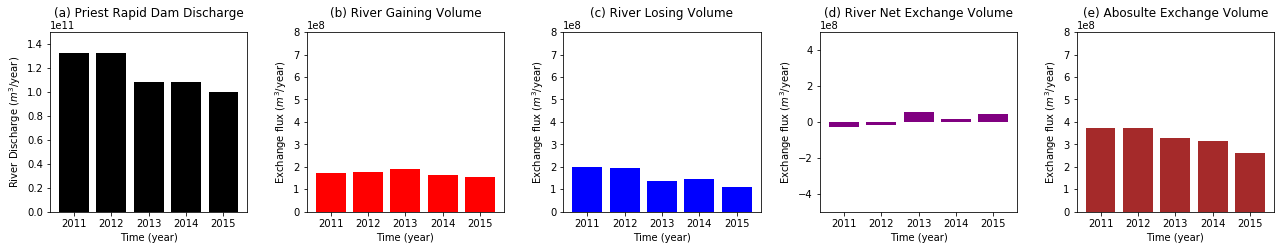

In [22]:
%matplotlib inline
start_year = 2011
# fig_name = fig_face_flux
gs = gridspec.GridSpec(1, 5)
fig = plt.figure()

ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(start_year + np.arange(n_segment), discharge_flow, color="black")
ax0.set_ylim([0, 1.5e11])
ax0.set_xlabel('Time (year)')
ax0.set_ylabel('River Discharge ($m^3$/year)')
ax0.set_title("(a) Priest Rapid Dam Discharge", y=1.05)

ax1 = fig.add_subplot(gs[0, 1])
ax1.bar(start_year + np.arange(n_segment), out_flow, color="red")
ax1.set_ylim([0, 8e8])
ax1.set_xlabel('Time (year)')
ax1.set_ylabel('Exchange flux ($m^3$/year)')
ax1.set_title("(b) River Gaining Volume", y=1.05)

ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(start_year + np.arange(n_segment), -in_flow, color="blue")
ax2.set_ylim([0, 8e8])
ax2.set_xlabel('Time (year)')
ax2.set_ylabel('Exchange flux ($m^3$/year)')
ax2.set_title("(c) River Losing Volume", y=1.05)

ax3 = fig.add_subplot(gs[0, 3])
ax3.bar(start_year + np.arange(n_segment), sum_flow, color="purple")
ax3.set_ylim([-5e8, 5e8])
ax3.set_xlabel('Time (year)')
ax3.set_ylabel('Exchange flux ($m^3$/year)')
ax3.set_title("(d) River Net Exchange Volume", y=1.05)

ax4 = fig.add_subplot(gs[0, 4])
ax4.bar(start_year + np.arange(n_segment), abs_flow, color="brown")
ax4.set_ylim([0, 8e8])
ax4.set_xlabel('Time (year)')
ax4.set_ylabel('Exchange flux ($m^3$/year)')
ax4.set_title("(e) Abosulte Exchange Volume", y=1.05)

fig.tight_layout()
fig.subplots_adjust(left=0.1,
                    right=0.95,
                    bottom=0.07,
                    top=0.85,
                    wspace=0.30,
                    hspace=0.38
                    )
fig.set_size_inches(20, 3.2)

In [23]:
fig.savefig(fig_face_flux, dpi=300, transparent=True)
plt.close(fig)

## plot face flux snapshot

In [28]:
# load pre-processed file
with open(fname_out_flux, "rb") as f:
    out_flux = pickle.load(f)
# times = np.sort(list(out_flux.keys()))
# simu_time = np.sort([np.float(i[5:19]) for i in times])  ## why i[5:19] ??

In [31]:
# add three lines to contour indicating mass1 location
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000
line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

In [ ]:
for itime in list(out_flux.keys())[:]:

#     itime =  list(out_flux.keys())[1078]
    real_itime = batch_delta_to_time(
        date_origin, [float(itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_itime]
    print(real_itime)
    xy_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for i_unique in np.arange(n_unique):
        xy_flux[unique_xy[i_unique, 1],
                unique_xy[i_unique, 0]] = out_flux[itime][i_unique]
    
    iout_flux = xy_flux * 24 / dx[0] / dy[0]
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
#     ax1.plot(line1_x, line1_y, "black", alpha =0.7)
#     ax1.plot(line2_x, line2_y, "black", alpha =0.7)
#     ax1.plot(line3_x, line3_y, "black", alpha =0.7)
    cf1 = ax1.imshow(iout_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    # plot river geometry
    ax1.plot(river_x, river_y, color='black', alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)       
    
    ax1.set_xlabel("X (km)")
    ax1.set_ylabel("Y (km)")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    cb1 = plt.colorbar(cf1, extend="both")
    cb1.ax.set_ylabel("Exchange flux (m/d)", rotation=270, labelpad=20)
#     fig.tight_layout()
    fig.set_size_inches(6, 5)

    fig_name = fig_face_snapshots + str(real_itime[0]) + ".jpg"    
    fig.savefig(fig_name, dpi=300, transparent = True)
    plt.close(fig)

**export flux data to .txt**

In [74]:
np.nanmean(iout_flux)

0.052592929171604193

In [69]:
fname = fig_face_snapshots + 'flux_' + str(real_itime[0]) + '.csv'
np.savetxt(fname, iout_flux, delimiter=",")

**count max, min for each year**

In [ ]:
max_flux = 0
min_flux = 0

for itime in list(out_flux.keys())[98:1558:20]:

    real_itime = batch_delta_to_time(
        date_origin, [float(itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_itime]
    print(real_itime)
    
    xy_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for i_unique in np.arange(n_unique):
        xy_flux[unique_xy[i_unique, 1],
                unique_xy[i_unique, 0]] = out_flux[itime][i_unique]
    
    iout_flux = xy_flux * 24 / dx[0] / dy[0]
    
    imax = np.nanmax(iout_flux)
    imin = np.nanmin(iout_flux)
    
    if imax > max_flux:
        max_flux = imax
    if imin < min_flux:
        min_flux = imin
        
print(max_flux, min_flux)

# Calculate accumulative flux for each river segment

In [14]:
# load pre-processed file
pickle_file = open(fname_out_flux, "rb")
out_flux = pickle.load(pickle_file)

In [14]:
times = np.sort(list(out_flux.keys()))
simu_time = np.sort([np.float(i[5:19]) for i in times]) 

In [15]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
real_time = batch_delta_to_time(
    date_origin, simu_time, "%Y-%m-%d %H:%M:%S", "hours")
real_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time]

time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

In [16]:
dt = np.diff(real_time).min()
dt = dt.days*24 + dt.seconds/3600 # convert timedelta to hours

**create out_flux dataframe**

In [17]:
columns = [str(e) for e in unique_river_cells]
out_flux_df = pd.DataFrame.from_dict(out_flux, orient='index')
out_flux_df.columns = columns # index is time, column is cell id

## divide river segments based on areas of HEF hot spots

In [18]:
block1 = ['Mass1_'+ str(e) for e in np.arange(318,332)]# region 332 is not included
block2 = ['Mass1_'+ str(e) for e in np.arange(296,318)]
block3 = ['Mass1_'+ str(e) for e in np.arange(272,296)]
block4 = ['Mass1_'+ str(e) for e in np.arange(233,272)]
block5 = ['Mass1_'+ str(e) for e in np.arange(199,233)]
block6 = ['Mass1_'+ str(e) for e in np.arange(165,199)]
block7 = ['Mass1_'+ str(e) for e in np.arange(132,165)]
block8 = ['Mass1_'+ str(e) for e in np.arange(113,132)]
block9 = ['Mass1_'+ str(e) for e in np.arange(65,113)]
block10 = ['Mass1_'+ str(e) for e in np.arange(41,65)]# region 40 is not included as it sum all cells prior to mass1-40 location

In [19]:
blocks = {'1':block1, '2':block2, '3':block3, '4':block4, '5':block5, '6':block6, '7':block7,
         '8':block8, '9':block9, '10':block10}

In [20]:
material_h5 = h5.File(fname_material_h5, "r")

abs_flow=[]
sum_flow=[]
in_flow=[]
out_flow=[]
for i in np.arange(1, 11)[:]:
    print('block:{}'.format(i))
    iblock = blocks[str(i)]
    i_river_cells=[]
    for i_MASS1 in iblock:
        temp_river_cells =  np.asarray(list(material_h5["Regions"][i_MASS1]["Cell Ids"]))
        temp_river_cells = temp_river_cells - 1
        # find cells not on the model boundary
        for i_cell in temp_river_cells:
            if (grids[i_cell, 0] > 0 and grids[i_cell, 0] < (nx - 1) and
            grids[i_cell, 1] > 0 and grids[i_cell, 1] < (ny - 1) and
            grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
                i_river_cells.append(i_cell)
    
    i_river_cells = np.asarray(i_river_cells).astype(int)
    i_unique_river_cells = np.unique(i_river_cells).astype(int)
    i_unique_river_cells = [str(e) for e in i_unique_river_cells]
    
    # get flux for each cells within block
    i_out_flux = out_flux_df.loc[:, i_unique_river_cells].values
    
    # calculate exchange flux for each block
    i_abs_flow = np.sum(np.abs(i_out_flux)) * dt
    i_sum_flow = np.sum(i_out_flux) * dt
    i_in_flow = sum(i_out_flux[i_out_flux >=0]) * dt
    i_out_flow = sum(i_out_flux[i_out_flux <=0]) * dt
    
    abs_flow.append(i_abs_flow)
    sum_flow.append(i_sum_flow)
    in_flow.append(i_in_flow) # losing
    out_flow.append(i_out_flow) # gaining

material_h5.close()

block:1
block:2
block:3
block:4
block:5
block:6
block:7
block:8
block:9
block:10


In [23]:
flux_metrix = pd.DataFrame(data = {'net_flow' : sum_flow, 'abs_flow' : abs_flow, 'losing_flow' : in_flow, 'gaining_flow' : out_flow })
flux_metrix.index = ['block'+ str(e) for e in np.arange(1,11)]

flux_metrix.to_csv(out_dir + 'flux_metrix_blocks.csv')

## divide river reach based on NEXSS comid

In [86]:
block1 = ['Mass1_'+ str(e) for e in np.arange(40,159)]
block2 = ['Mass1_'+ str(e) for e in np.arange(159,250)]
block3 = ['Mass1_'+ str(e) for e in np.arange(250,261)]
block4 = ['Mass1_'+ str(e) for e in np.arange(261,272)]
block5 = ['Mass1_'+ str(e) for e in np.arange(272,275)]
block6 = ['Mass1_'+ str(e) for e in np.arange(275,279)]
block7 = ['Mass1_'+ str(e) for e in np.arange(279,291)]
block8 = ['Mass1_'+ str(e) for e in np.arange(291,299)]
block9 = ['Mass1_'+ str(e) for e in np.arange(299,320)]
block10 = ['Mass1_'+ str(e) for e in np.arange(320,329)]
block11 = ['Mass1_'+ str(e) for e in np.arange(329,333)]

In [87]:
blocks = {'1':block1, '2':block2, '3':block3, '4':block4, '5':block5, '6':block6, '7':block7,
         '8':block8, '9':block9, '10':block10, '11':block11}

In [90]:
material_h5 = h5.File(fname_material_h5, "r")

abs_flow=[]
sum_flow=[]
in_flow=[]
out_flow=[]
for i in np.arange(1, 12)[:]:
    print('block:{}'.format(i))
    iblock = blocks[str(i)]
    i_river_cells=[]
    for i_MASS1 in iblock:
        temp_river_cells =  np.asarray(list(material_h5["Regions"][i_MASS1]["Cell Ids"]))
        temp_river_cells = temp_river_cells - 1
        # find cells not on the model boundary
        for i_cell in temp_river_cells:           
            if (grids[i_cell, 0] > 0 and grids[i_cell, 0] < (nx - 1) and
            grids[i_cell, 1] > 0 and grids[i_cell, 1] < (ny - 1) and
            grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
                i_river_cells.append(i_cell)
                
    i_river_cells = np.asarray(i_river_cells).astype(int)
    i_unique_river_cells = np.unique(i_river_cells).astype(int)
    i_unique_river_cells = [str(e) for e in i_unique_river_cells]
    
    # get flux for each cells within block
    i_out_flux = out_flux_df.loc[:, i_unique_river_cells].values
    
    # calculate mean annual exchange flux for each block
    i_abs_flow = np.sum(np.abs(i_out_flux)) * dt / 5
    i_sum_flow = np.sum(i_out_flux) * dt / 5
    i_in_flow = sum(i_out_flux[i_out_flux >=0]) * dt / 5
    i_out_flow = sum(i_out_flux[i_out_flux <=0]) * dt / 5
    
    abs_flow.append(i_abs_flow)
    sum_flow.append(i_sum_flow)
    in_flow.append(i_in_flow) # losing
    out_flow.append(i_out_flow) # gaining

material_h5.close()

block:1
block:2
block:3
block:4
block:5
block:6
block:7
block:8
block:9
block:10
block:11


In [92]:
flux_metrix = pd.DataFrame(data = {'net_flow' : sum_flow, 'abs_flow' : abs_flow, 'losing_flow' : in_flow, 'gaining_flow' : out_flow })
flux_metrix.index = ['block'+ str(e) for e in np.arange(1,12)]

flux_metrix.to_csv(out_dir + 'face_flux/flux_metrix_NEXSS_blocks.csv')

# read sinuosity, thickness, flux file

In [25]:
sinuosity_thickness_flux = pd.read_csv(fname_sinuosity_thickness_flux)

In [26]:
sinuosity = sinuosity_thickness_flux['sinuosity'].values

In [27]:
abs_flow_per_channel_length = sinuosity_thickness_flux['exchange volume per channel length (m3/km)'].values

In [28]:
# read mass1 coordinates
mass1_coord = pd.read_csv(fname_mass1_coord)

In [29]:
mass1_coord['easting'] = (mass1_coord['easting'] - model_origin[0])/1000
mass1_coord['northing'] = (mass1_coord['northing'] - model_origin[1])/1000

In [30]:
selected_mass1 = np.array([40, 65, 113, 132, 165, 199, 233, 272, 296, 318, 333])
selected_mass1 = selected_mass1 - 40

## plot exchang flux versus sinuosity

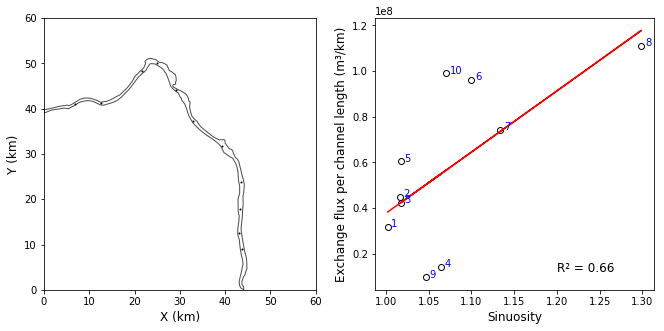

In [33]:
%matplotlib inline
fig, (ax1, ax) = plt.subplots(1,2)

# plot river geometry
ax1.plot(river_x, river_y, color='black', alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)       

ax1.set_xlabel("X (km)", fontsize=12)
ax1.set_ylabel("Y (km)", fontsize=12)
#     ax1.set_aspect("equal", "datalim")
ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])

# add mass1 points
for i in selected_mass1:
    xmass = mass1_coord.iloc[i, 1]
    ymass = mass1_coord.iloc[i, 2]
    ax1.plot(xmass, ymass, 'k.', markersize=2)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)    
    
ax1.set_aspect('equal')    

ax.plot(sinuosity, abs_flow_per_channel_length, 'ko', mfc='none')

names = [str(e) for e in np.arange(1, 11)]
# Fit with polyfit
b, m = polyfit(sinuosity, abs_flow_per_channel_length, 1)
Y = b + m * np.asarray(sinuosity)
# get stats
slope, intercept, r_value, p_value, std_err = stats.linregress(sinuosity, abs_flow_per_channel_length)

ax.plot(sinuosity, Y, 'r-')
plt.text(1.20, 1.2e7, 'R\u00b2 = {0:.2f}'.format(r_value**2), fontsize = 12)

for i, txt in enumerate(names):
    ax.annotate(txt, (sinuosity[i] + 0.004, abs_flow_per_channel_length[i] ), color = 'blue')

ax.set_xlabel('Sinuosity', fontsize=12)
ax.set_ylabel('Exchange flux per channel length (m\u00b3/km)', fontsize=12)

ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

# fig.tight_layout()
fig.set_size_inches(11, 5)

In [27]:
fig.savefig(out_dir + 'face_flux/sinuosity.eps', dpi=300, transparent=True, format='eps')
plt.close(fig)

## plot flux versus thickness of hf

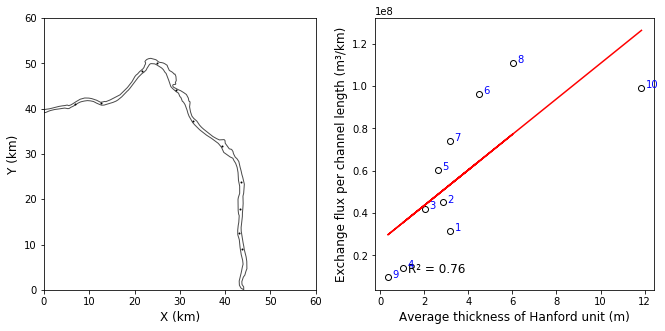

In [34]:
hf_thickness= sinuosity_thickness_flux['thickness of hf (m)'].values

%matplotlib inline
fig, (ax1, ax) = plt.subplots(1,2)

# plot river geometry
ax1.plot(river_x, river_y, color='black', alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)       

ax1.set_xlabel("X (km)", fontsize=12)
ax1.set_ylabel("Y (km)", fontsize=12)
#     ax1.set_aspect("equal", "datalim")
ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])

# add mass1 points
for i in selected_mass1:
    xmass = mass1_coord.iloc[i, 1]
    ymass = mass1_coord.iloc[i, 2]
    ax1.plot(xmass, ymass, 'k.', markersize=2)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)    

ax1.set_aspect('equal')

ax.plot(hf_thickness, abs_flow_per_channel_length, 'ko', mfc='none')

names = [str(e) for e in np.arange(1, 11)]

# Fit with polyfit
b, m = polyfit(hf_thickness, abs_flow_per_channel_length, 1)
Y = b + m * np.asarray(hf_thickness)
# get stats
slope, intercept, r_value, p_value, std_err = stats.linregress(hf_thickness, abs_flow_per_channel_length)

ax.plot(hf_thickness, Y, 'r-')
plt.text(1.25, 1.2e7, 'R\u00b2 = {0:.2f}'.format(r_value**2), fontsize = 12)

for i, txt in enumerate(names):
    ax.annotate(txt, (hf_thickness[i] + 0.2, abs_flow_per_channel_length[i] ), color = 'blue')

ax.set_xlabel('Average thickness of Hanford unit (m)', fontsize=12)
ax.set_ylabel('Exchange flux per channel length (m\u00b3/km)', fontsize=12)

ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

# fig.tight_layout()
fig.set_size_inches(11, 5)

In [21]:
fig.savefig(out_dir + 'face_flux/hf_thickness.eps', dpi=300, transparent=True, format='eps')
plt.close(fig)

## Multivariate regression

In [35]:
df = sinuosity_thickness_flux.rename(columns={'thickness of hf (m)': 'thickness', 'exchange volume per channel length (m3/km)': 'flux'})

result = smf.ols(formula= "flux ~ sinuosity + thickness", data = df).fit()

result.summary()

/global/homes/p/pshuai/.conda/envs/nersc/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   flux   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     12.02
Date:                Fri, 07 Dec 2018   Prob (F-statistic):            0.00545
Time:                        15:36:03   Log-Likelihood:                -180.18
No. Observations:                  10   AIC:                             366.4
Df Residuals:                       7   BIC:                             367.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.689e+08   8.09e+07     -2.087      0.075    -3.6e+08    2.24e+07
sinuosity   1.875e+08    7.7e+07      2.436      0.045    5.49e+06     3.7e+08
thickness   6.748e+06   2.08e+06      3.240      0.014    1.82e+06    1.17e+07
==============================================================================
Omnibus:                        0.457   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.507
Skew:                           0.243   Prob(JB):                        0.776
Kurtosis:                       2.009   Cond. No.                         91.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
text_file = open(fname_regression_summary, "w")
text_file.write(result.summary().as_text())
text_file.close()

/global/homes/p/pshuai/.conda/envs/nersc/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


**ANOVA**

In [36]:
anova = sm.stats.anova_lm(result, typ = 2)

In [37]:
anova

sum_sq   df          F    PR(>F)
sinuosity  2.216518e+15  1.0   5.934145  0.045022
thickness  3.922073e+15  1.0  10.500320  0.014245
Residual   2.614636e+15  7.0        NaN       NaN

In simple regression, the proportion of **variance explained** is equal to $r^2$ (coefficient of determination); in multiple regression, it is equal to $R^2$. Variance explained is calculated from: $$\eta^2 = sum\_sq_i / sum\_sq_{total} $$ For example, variance explained by thickness = (sum_sq_tk)/(sum_sq_sino + sum_sq_tk + sum_sq_resi) = 0.88
[(link)](http://onlinestatbook.com/2/effect_size/variance_explained.html)

**forward selection**

In [53]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print(best_candidate, '%.2f'%best_new_score, '%.3f'% (best_new_score-current_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [47]:
df = sinuosity_thickness_flux.rename(columns={'thickness of hf (m)': 'thickness', 'exchange volume per channel length (m3/km)': 'flux'})
df = df[['sinuosity', 'thickness', 'flux'] ]

In [54]:
model = forward_selected(df, 'flux')

thickness 0.88 0.884
sinuosity 0.91 0.022


In [52]:
print(model.model.formula), print(model.rsquared_adj)

flux ~ thickness + sinuosity + 1
0.906561866853


(None, None)